# Uncertainy for a synthetic regression task with dropout using the setup from https://arxiv.org/abs/2204.09308

In [1]:
import numpy as np
%load_ext autoreload
%autoreload 2

from probly.representation.dropout import Dropout
from probly.quantification.regression import total_uncertainty_variance, aleatoric_uncertainty_variance, \
    epistemic_uncertainty_variance

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt

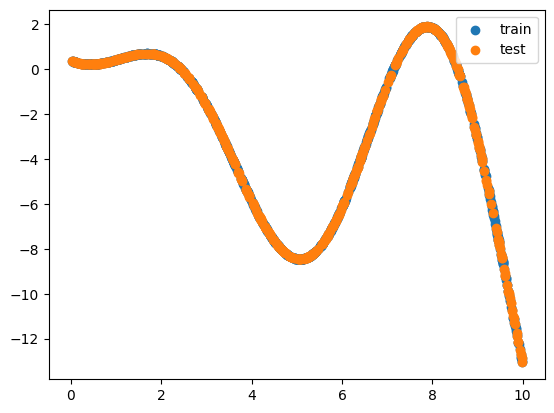

In [2]:
epochs = 700
bs = 32
eps1 = np.random.normal(0, 0.3)
eps2 = np.random.normal(0, 0.3)
# Generate data points between 0 and 10
X = np.expand_dims(np.random.uniform(0, 10, 1500), axis=1)
X_train = X[:1000]
X_test = X[1000:]
# Generate labels
y = X * np.sin(X) + eps1 * X + eps2
y_train = y[:1000]
y_test = y[1000:]

plt.scatter(X_train, y_train, label='train')
plt.scatter(X_test, y_test, label='test')
plt.legend()
plt.show()

X_ood = np.expand_dims(np.random.uniform(10, 15, 200), axis=1)



train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)), batch_size=bs, shuffle=True)
test_loader = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)), batch_size=bs, shuffle=False)

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc31 = nn.Linear(32, 1)
        self.fc32 = nn.Linear(32, 1)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        mu = self.fc31(x)
        sigma2 = F.softplus(self.fc32(x))
        x = torch.cat([mu, sigma2], dim=1)
        return x

net = Net()
model = Dropout(net)
optimizer = optim.Adam(model.parameters())
criterion = nn.GaussianNLLLoss()

In [4]:
for _ in tqdm(range(epochs)):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs, 1)
        mean = outputs[:, :, 0]
        var = outputs[:, :, 1]
        loss = criterion(mean, targets, var)
        loss.backward()
        optimizer.step()
model.eval()

100%|██████████| 700/700 [00:13<00:00, 52.92it/s]


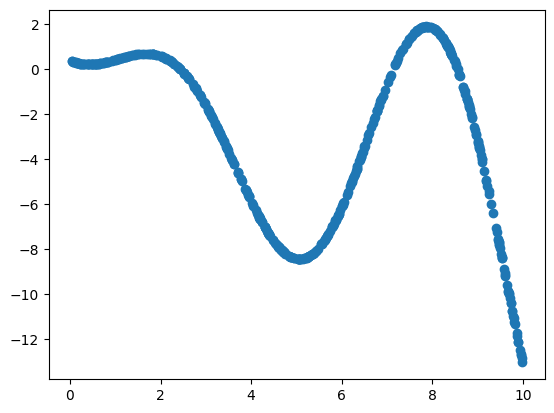

In [5]:
y_pred = model(torch.from_numpy(X_test).float(), 100).detach().cpu().numpy()
plt.scatter(X_test, y_test.mean(axis=1))
tu = total_uncertainty_variance(y_pred)
au = aleatoric_uncertainty_variance(y_pred)
eu = epistemic_uncertainty_variance(y_pred)